In [2]:
class Element:
    def __init__(self, value):
        value = value
        next = None
    
ele_list = [Element(1), Element(2), Element(3), Element(4), Element(5)]
min(ele_list, key=lambda x: x.value).value

1

(True, 1)


/tmp/ipykernel_76947/2783806787.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


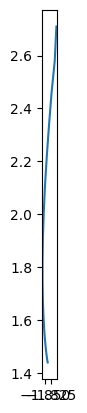

In [9]:
import numpy as np
import matplotlib.pyplot as plt

path = [(-1.8062234491964542, 2.7098184497742377, -1.619855462616086), (-1.8126093760743336, 2.5797549512001936, -1.6691448212842608), (-1.8248841767333615, 2.455348375607629, -1.6491026994865374), (-1.8344002773827994, 2.334072905774875, -1.6418540531351384), (-1.8426878823411341, 2.217637268245199, -1.6317310588285192), (-1.8494190115248645, 2.1073094484792083, -1.6173872831729499), (-1.854232899360396, 2.00406185476328, -1.6026431410243969), (-1.8572678251522057, 1.9087964485121376, -1.5871902907888569), (-1.8586881715199728, 1.8221658373347176, -1.570595898771984), (-1.8586726339140855, 1.7446437151614742, -1.553252380738296), (-1.8574773181596496, 1.6765180430558764, -1.5353117891041859), (-1.8553958417388896, 1.6178839773247802, -1.5168667881933522), (-1.8527378947684419, 1.5686462172239712, -1.49798270084864), (-1.849810906762225, 1.5285189285867127, -1.4787188585554392), (-1.8469029806194994, 1.4970269306204627, -1.4591674819232985), (-1.8442662906640397, 1.47350497337697, -1.4394194721850835), (-1.8420982402108896, 1.4570974969265649, -1.4195729051866257), (-1.8405227443579193, 1.4467587032914735, -1.3997700552533383), (-1.8395717712946804, 1.44125263138164, -1.380359613327978), (-1.8391670585827253, 1.439153202239187, -1.380359613327978)]
path_array = np.array(path)
plt.plot(path_array[:, 0], path_array[:, 1])
plt.axes().set_aspect('equal')

import pickle
from scipy.spatial import KDTree
import math

_spatial_temporal_obstacles_array = pickle.load(open('/home/shaohang/work_space/autonomous_vehicle/ISS/obstacle.pkl', 'rb'))
_spatial_temporal_obstacles = KDTree(_spatial_temporal_obstacles_array)

_obstacles_info_list = pickle.load(open('/home/shaohang/work_space/autonomous_vehicle/ISS/obstacle_info.pkl', 'rb'))

def get_circle_centers(x, y, heading_angle, length, width, num_circles=3):
    spacing = length / num_circles
    centers = [(x + spacing * (j - (num_circles + 1) / 2) * math.cos(heading_angle),
                y + spacing * (j - (num_circles + 1) / 2) * math.sin(heading_angle))
               for j in range(1, num_circles + 1)]
    r = 0.5 * math.sqrt((length / num_circles) ** 2 + width ** 2)
    return centers, r

def collision_check(path):
    if _spatial_temporal_obstacles is None:
        return False, 0
    ego_length = 0.35
    ego_width = 0.2
    for i, wpt in enumerate(path):
        ego_heading = wpt[2]
        ego_center = [wpt[0], wpt[1]]
        ego_circle_centers, ego_radius = get_circle_centers(ego_center[0], ego_center[1], ego_heading, ego_length, ego_width)
        for ego_circle_center in ego_circle_centers:
            ego_circle_center_array = np.array(ego_circle_center)
            possible_obstacles = _spatial_temporal_obstacles.query_ball_point(ego_circle_center_array, 6 * ego_radius)
            for idx in possible_obstacles:
                obs_info = _obstacles_info_list[idx]
                if obs_info[0] in [(i + j) for j in range(-1, 2)]:                    
                    dist = np.linalg.norm(ego_circle_center_array - _spatial_temporal_obstacles.data[idx])
                    if dist < (ego_radius + obs_info[1]):
                        return True, 1
    return False, 0

print(collision_check(path))
